# Step 2
### Data Viz
<br>

----

#### Load Cities File

In [1]:
import pandas as pd
import numpy as np


In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone


In [3]:
cities_data = pd.read_pickle("../data/pickles/cities_1.pkl")


#### Make City Centers

In [4]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../src')))

from make_clusters import make_clusters

In [5]:
pipeline_list = []

latitude_bounds = []
longitude_bounds = []

city_centers = []
city_ratios = []

for cur_row in cities_data.itertuples():
    tmp_data = cur_row.rentals.copy()
    tmp_data["log_price"] = np.log10(tmp_data.price)
    tmp_data = tmp_data[["longitude","latitude","log_price", "weight"]]
    
    cloned_pipeline = make_clusters(tmp_data, "log_price", 1)
    pipeline_list.append(cloned_pipeline)
    
    tmp_data = tmp_data[["longitude","latitude"]]
    
    cur_probas = -1 * cloned_pipeline.score_samples(tmp_data)
    focus_indices = np.argsort(cur_probas)[0:int(np.ceil(len(cur_probas)*0.625))]

    tmp_data = tmp_data.iloc[focus_indices]
    
    city_latitude_bounds = ( np.min(tmp_data.latitude), np.max(tmp_data.latitude) )    
    city_longitude_bounds = ( np.min(tmp_data.longitude), np.max(tmp_data.longitude) )
    
    city_longitude, city_latitude = cloned_pipeline.steps[0][-1].inverse_transform(
        cloned_pipeline.steps[-1][-1].means_
    )[0]

    meter_per_latitude = 69.17
    meter_per_longitude = np.cos( city_latitude * ( 2*np.pi / 360 ) ) * ( 24900 / 360 )

    cur_city_ratio = meter_per_latitude / meter_per_longitude
    cur_city_ratio *= 1.5
    
    cur_width = (
        city_latitude_bounds[1] - city_latitude_bounds[0]
    ) * cur_city_ratio

    if cur_width > np.diff(city_latitude_bounds)[0]:
        city_longitude_bounds = (
            city_longitude - 3/3 * cur_width / 2,
            city_longitude + 3/3 * cur_width / 2
        )
        
        city_latitude_bounds = (
            city_latitude - (1/cur_city_ratio) * cur_width / 2,
            city_latitude + (1/cur_city_ratio) * cur_width / 2
        )
    else:
        cur_width = (
            city_longitude_bounds[1] - city_longitude_bounds[0]
        ) / cur_city_ratio

        city_latitude_bounds = (
            city_latitude - 3/3 * cur_width / 2,
            city_latitude + 3/3 * cur_width / 2
        )
        
        city_longitude_bounds = (
            city_longitude - (cur_city_ratio) * cur_width / 2,
            city_longitude + (cur_city_ratio) * cur_width / 2
        )
        
    latitude_bounds.append(city_latitude_bounds)
    longitude_bounds.append(city_longitude_bounds)
    
    city_centers.append((city_latitude, city_longitude))
    city_ratios.append(cur_city_ratio)
    
cities_data["center_pipelines"] = pipeline_list
    
cities_data["latitude_bounds"] = latitude_bounds
cities_data["longitude_bounds"] = longitude_bounds

cities_data["city_centers"] = city_centers
cities_data["city_ratios"] = city_ratios


1927
1734
1768
13374
12036
12282
28829
25946
26683
5668
5101
5046


#### Plot City Centers

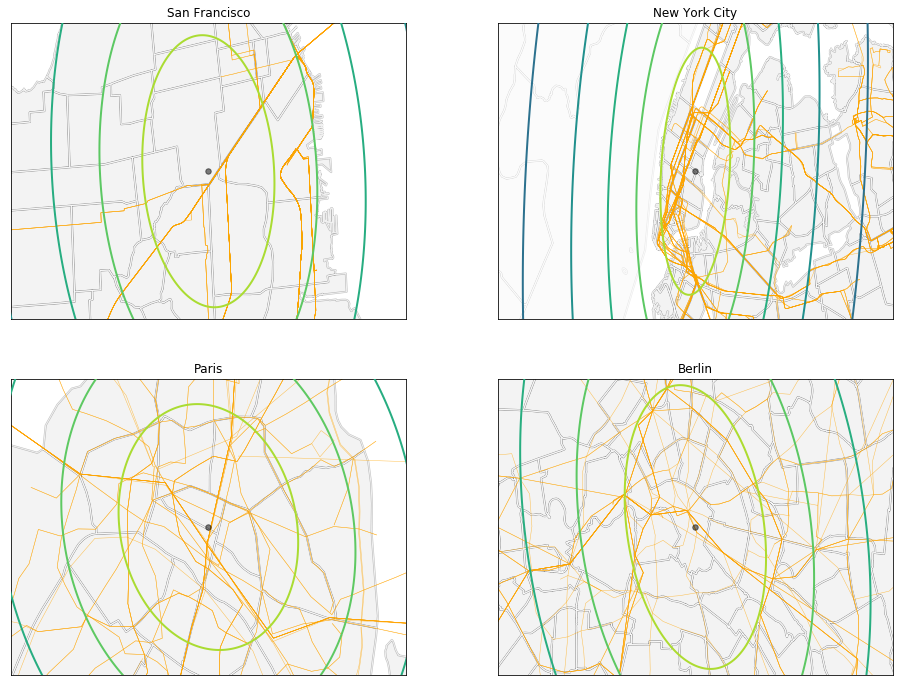

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt 

from plots.make_clusters_plot import make_clusters_plot

plt.figure(figsize=(16,12))
    
for cur_index, cur_city_data in enumerate(cities_data.itertuples()):
    plt.subplot(2,2,cur_index+1)
    make_clusters_plot(cur_city_data, pipeline_list[cur_index])


In [7]:
cities_data.to_pickle("../data/pickles/cities_2.pkl")


#### Plot City Rentals

In [8]:
import matplotlib.pyplot as plt 

import os
import sys
sys.path.append(os.path.abspath(os.path.join('../src')))

from plots.make_rentals_plot import make_rentals_plot


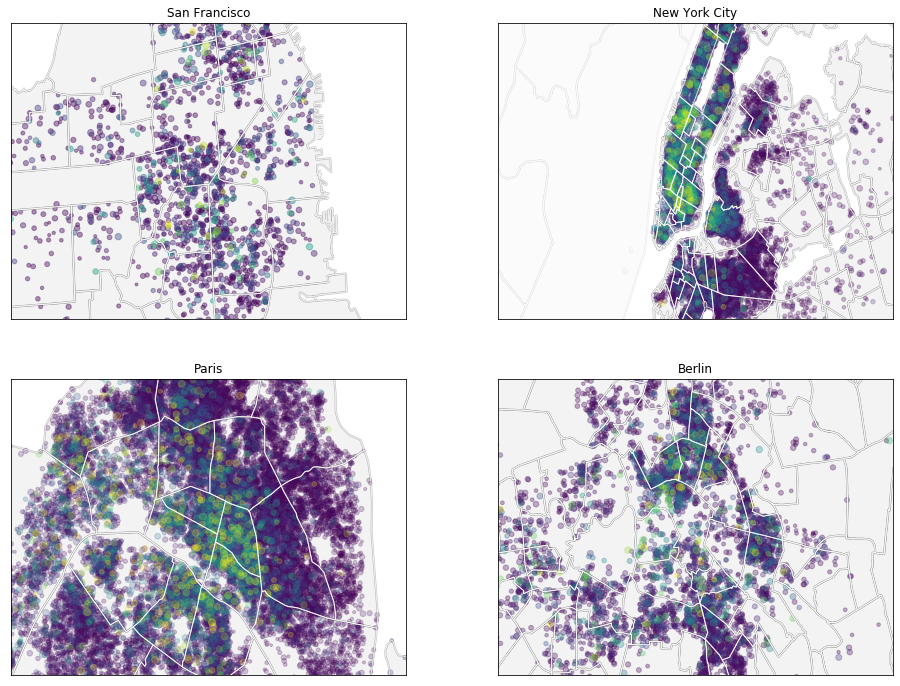

In [9]:
plt.figure(figsize=(16,12))
    
for cur_index, cur_city_data in enumerate(cities_data.itertuples()):
    plt.subplot(2,2,cur_index+1)
    make_rentals_plot(cur_city_data)
